In [3]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import time  # 計時用, 目前沒用到
import gc  # 記憶體的垃圾回收, 用法: gc.collect()
import os  # 建立資料夾
import matplotlib.pyplot as plt  # 畫圖用
import json  # 儲存 Session 的統計資料用
plt.rcParams['font.family']=['Noto Sans TC'] # 中文顯示

/Users/bula/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/bula/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [4]:
DATA_DIR = 'data'

### 1. 分群之前

In [5]:
# load member features
member_df = pd.read_csv(f'MemberA_behavior_data/member_features(不含退貨).csv')
print("member_df", member_df.shape)
display(member_df.head(1))

member_df (26598, 13)


,MemberID,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
0,GhKK5xXtrl1ZjIyXUY7Qr5hRqMwkbLvwMFqEObZ2oeI=,363.8154,1397.999,21.769231,9.0,3.769231,1.285714,3012.718,2983.357,34.487,5.5,1.0,846.43632


In [ ]:
# 哪個 columns 有 nan
print("member_df columns with NaN:")
print(member_df.columns[member_df.isna().any()].tolist())

# 有多少含有 NaN 的 row
print("member_df rows with NaN:", member_df.isna().any(axis=1).sum())

member_df columns with NaN:
['view_to_buy_duration_median', 'add_to_buy_duration_median', 'view_to_add_duration_median', 'purchase_randomess']
member_df rows with NaN: 2149


In [28]:
# 哪個 columns 有 inf
numeric_df = member_df.select_dtypes(include=[np.number])
print("member_df columns with inf:")
print(numeric_df.columns[np.isinf(numeric_df).any()].tolist())

# 有多少含有 inf 的 row
print("member_df rows with inf:", np.isinf(numeric_df).any(axis=1).sum())

member_df columns with inf:
['dicount_sensitivity']
member_df rows with inf: 654


In [19]:
member_df

,MemberID,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
0,GhKK5xXtrl1ZjIyXUY7Qr5hRqMwkbLvwMFqEObZ2oeI=,363.815400,1.397999e+03,21.769231,9.0,3.769231,1.285714,3012.7180,2983.3570,34.4870,5.500000,1.000000,846.436320
1,BEE1QykNZUQ6VNPmnkoPv7Ry34rSi24eQAtlDacWUJc=,337607.951000,3.376080e+05,5.952381,4.0,0.523810,1.000000,477.8220,322.6850,155.1370,4.000000,2.000000,NaN
2,XJXKHR+cTo9cwinRalfkVOvshVhvNtw+SzZ5WPme5+0=,61.668167,3.700090e+02,12.166667,10.5,2.833333,0.400000,672.0330,669.3110,2.7220,6.000000,1.125000,0.000000
3,WRy4jrS8JIRXqYXZdybGv/w702dnGrxYQzcEgmfCzN8=,12.232105,8.075800e+01,11.761905,8.0,2.714286,1.428571,827.7020,775.6990,7.5420,15.000000,1.000000,0.000000
4,CHL7cDPUa1iy/mwfOokQOFQ/iCExGp/RpWr4xh/ZB5M=,99.733385,1.209517e+03,41.000000,41.0,21.000000,0.750000,1480.0025,1472.0495,6.7085,0.500000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26593,yNBuS+pj8BeUnvD0a3641B/WuQiQ7CfDc08r3ZPZQ/A=,329397.730604,1.021081e+07,21.423729,10.0,4.328814,0.706806,59045.6580,41109.8115,39.3370,4.750000,1.432049,814.492473
26594,9hMBEuoZHPm0KheEgqtLkvextSbsG18yVG/kU0BNRqc=,4.174727,4.592200e+01,8.235294,4.0,1.411765,0.125000,NaN,NaN,NaN,8.000000,1.000000,NaN
26595,YdCXdhtOGdHFm3k6ddxfJEKAMEqicfs9ItIEg+t02Do=,10.783957,1.599910e+02,9.809524,6.0,3.142857,1.153846,472.5845,437.7870,22.4935,0.250000,1.000000,455.088636
26596,ArNx5xzqOKsi03eEIMoFY4OgncNy4OBFz+blij7hLK0=,865152.719600,8.650766e+06,12.769231,6.0,2.384615,2.000000,1386.7875,327.6050,68.5250,2.333333,1.153846,517.952287


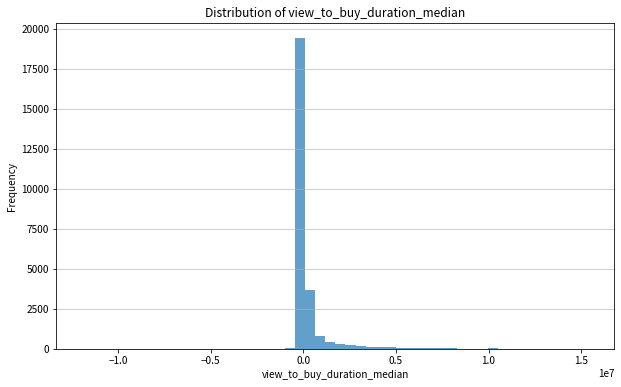

In [25]:
# plt columns 分佈
col_name = 'view_to_buy_duration_median'
plt.figure(figsize=(10, 6))
plt.hist(member_df[f'{col_name}'], bins=50, alpha=0.7)
plt.title(f'Distribution of {col_name}')
plt.xlabel(f'{col_name}')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

### 2. K-means 分群

In [23]:
# 每個 columns 的統計資料
print("member_df columns statistics:")
display(member_df.describe())

member_df columns statistics:


/Users/bula/opt/anaconda3/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
count,2.659800e+04,2.659800e+04,26598.000000,26598.000000,26598.000000,26598.000000,2.576900e+04,2.590100e+04,2.524600e+04,26598.0,26598.000000,25440.000000
mean,3.333049e+05,3.715593e+06,15.425332,8.068257,4.225234,0.751805,3.281206e+05,2.455960e+05,3.397244e+04,inf,1.353943,168.349051
std,7.085026e+05,4.543698e+06,10.285374,8.702559,4.537130,0.582386,1.212287e+06,9.909413e+05,6.906175e+05,NaN,0.391810,285.522227
min,0.000000e+00,0.000000e+00,1.333333,1.000000,0.007828,0.000000,-1.195909e+07,-1.295489e+07,-1.531150e+07,0.0,1.000000,0.000000
25%,5.151919e+02,3.278406e+03,9.619683,4.500000,1.758955,0.384615,7.871750e+02,6.740365e+02,6.380750e+00,2.0,1.120000,0.000000
50%,8.759606e+04,1.148739e+06,13.049291,6.000000,3.000000,0.650000,3.122764e+03,2.258822e+03,1.656650e+01,4.0,1.272727,72.416811
75%,4.110102e+05,7.101603e+06,18.083333,9.000000,5.100000,1.000000,8.346191e+04,5.332348e+04,5.009900e+01,7.5,1.478261,240.299774
max,1.545095e+07,1.565112e+07,210.000000,210.000000,114.000000,16.571429,1.541916e+07,1.443080e+07,1.522667e+07,inf,13.000000,21513.750815


In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# 儲存 member_id 以後面合併
member_ids = member_df['MemberID']
X = member_df.drop(columns=['MemberID'])  # 去掉 MemberID, 只留下特徵 X

# cat features: 自動只對 cat feature 做 1-hot
#X = pd.get_dummies(X, drop_first=True)  # 丟掉第一個類別 ∵ vec=0

# 對 inf 取代為 0, 因為是某個 / 0 的結果
X_noinf = X.replace([np.inf, -np.inf], np.nan)  # 先把 inf 轉成 NaN

# 平均值填補 NaN
imputer = SimpleImputer(strategy='mean')
X_filled = imputer.fit_transform(X_noinf)

# num features: 標準化數值
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
display(X_scaled_df)

,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess,cluster
0,-0.469931,-0.817454,0.616800,0.107067,-0.100507,0.916780,-0.272462,-0.248108,-0.050441,-0.044555,-0.903371,2.428400e+00,0.739095
1,0.006074,-0.743458,-0.921029,-0.467487,-0.815823,0.426177,-0.274587,-0.250829,-0.050262,-0.264331,1.648933,1.017852e-16,0.739095
2,-0.470357,-0.817680,-0.316831,0.279434,-0.306786,-0.604087,-0.274424,-0.250474,-0.050488,0.028704,-0.584333,-6.028999e-01,0.739095
3,-0.470427,-0.817744,-0.356185,-0.007843,-0.333025,1.162081,-0.274293,-0.250365,-0.050481,1.347360,-0.903371,-6.028999e-01,0.739095
4,-0.470304,-0.817496,2.486555,3.784216,3.697289,-0.003100,-0.273747,-0.249653,-0.050482,-0.777141,-0.903371,-6.028999e-01,0.010059
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26593,-0.005515,1.429527,0.583208,0.221978,0.022830,-0.077268,-0.225503,-0.209118,-0.050434,-0.154443,0.199348,2.314001e+00,-1.448012
26594,-0.470439,-0.817752,-0.699068,-0.467487,-0.620111,-1.076292,0.000000,0.000000,0.000000,0.321738,-0.903371,1.017852e-16,0.739095
26595,-0.470429,-0.817727,-0.546010,-0.237665,-0.238564,0.690348,-0.274591,-0.250711,-0.050459,-0.813771,-0.903371,1.026886e+00,0.739095
26596,0.750679,1.086178,-0.258245,-0.237665,-0.405687,2.143285,-0.273825,-0.250824,-0.050391,-0.508526,-0.510709,1.252016e+00,-1.448012


In [39]:
# KMeans 分群 (分 4 群)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled_df)

# 加入分群結果
member_df['cluster'] = clusters
display(member_df)

,MemberID,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess,cluster
0,GhKK5xXtrl1ZjIyXUY7Qr5hRqMwkbLvwMFqEObZ2oeI=,363.815400,1.397999e+03,21.769231,9.0,3.769231,1.285714,3012.7180,2983.3570,34.4870,5.500000,1.000000,846.436320,3
1,BEE1QykNZUQ6VNPmnkoPv7Ry34rSi24eQAtlDacWUJc=,337607.951000,3.376080e+05,5.952381,4.0,0.523810,1.000000,477.8220,322.6850,155.1370,4.000000,2.000000,NaN,3
2,XJXKHR+cTo9cwinRalfkVOvshVhvNtw+SzZ5WPme5+0=,61.668167,3.700090e+02,12.166667,10.5,2.833333,0.400000,672.0330,669.3110,2.7220,6.000000,1.125000,0.000000,3
3,WRy4jrS8JIRXqYXZdybGv/w702dnGrxYQzcEgmfCzN8=,12.232105,8.075800e+01,11.761905,8.0,2.714286,1.428571,827.7020,775.6990,7.5420,15.000000,1.000000,0.000000,3
4,CHL7cDPUa1iy/mwfOokQOFQ/iCExGp/RpWr4xh/ZB5M=,99.733385,1.209517e+03,41.000000,41.0,21.000000,0.750000,1480.0025,1472.0495,6.7085,0.500000,1.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26593,yNBuS+pj8BeUnvD0a3641B/WuQiQ7CfDc08r3ZPZQ/A=,329397.730604,1.021081e+07,21.423729,10.0,4.328814,0.706806,59045.6580,41109.8115,39.3370,4.750000,1.432049,814.492473,0
26594,9hMBEuoZHPm0KheEgqtLkvextSbsG18yVG/kU0BNRqc=,4.174727,4.592200e+01,8.235294,4.0,1.411765,0.125000,NaN,NaN,NaN,8.000000,1.000000,NaN,3
26595,YdCXdhtOGdHFm3k6ddxfJEKAMEqicfs9ItIEg+t02Do=,10.783957,1.599910e+02,9.809524,6.0,3.142857,1.153846,472.5845,437.7870,22.4935,0.250000,1.000000,455.088636,3
26596,ArNx5xzqOKsi03eEIMoFY4OgncNy4OBFz+blij7hLK0=,865152.719600,8.650766e+06,12.769231,6.0,2.384615,2.000000,1386.7875,327.6050,68.5250,2.333333,1.153846,517.952287,0


cluster
3    16694
0     8147
2      990
1      767
Name: count, dtype: int64


<Axes: title={'center': 'Cluster Distribution'}, xlabel='cluster'>

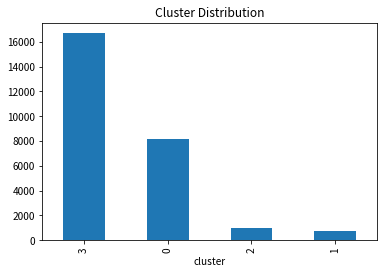

In [82]:
print(member_df['cluster'].value_counts())
member_df['cluster'].value_counts().plot(kind='bar', title='Cluster Distribution')

### 3. 分群之後：觀察不同群體，在各個 features 的差異

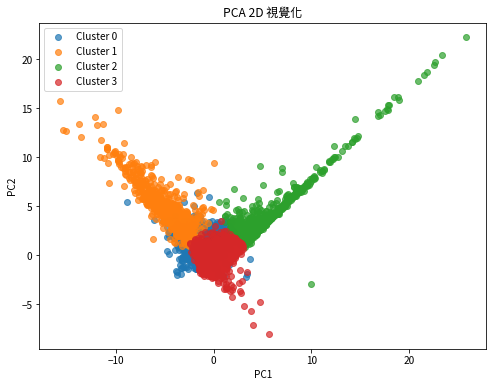

In [46]:
# PCA, t-SNE 視覺化
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled_df)

plt.figure(figsize=(8,6))
for cluster_id in sorted(member_df['cluster'].unique()):
    plt.scatter(
        pca_result[member_df['cluster'] == cluster_id, 0],
        pca_result[member_df['cluster'] == cluster_id, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.7
    )
plt.title('PCA 2D 視覺化')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


In [47]:
from sklearn.manifold import TSNE

# perplexity <= samples
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(X_scaled_df)

plt.figure(figsize=(8,6))
for cluster_id in sorted(member_df['cluster'].unique()):
    plt.scatter(
        tsne_result[member_df['cluster'] == cluster_id, 0],
        tsne_result[member_df['cluster'] == cluster_id, 1],
        label=f'Cluster {cluster_id}',
        alpha=0.7
    )
plt.title('t-SNE 2D 視覺化')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [89]:
# 看各個群的平均值
cluster_summary = X_noinf.copy()  # X_scaled_df
cluster_summary['cluster'] = member_df['cluster']
group_means = cluster_summary.groupby('cluster').mean()

display(group_means)

cluster_summary = X_scaled_df.copy()  # 
cluster_summary['cluster'] = member_df['cluster']
group_means = cluster_summary.groupby('cluster').mean()

display(group_means)

,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
cluster,,,,,,,,,,,,
0,7.035222e+05,9.175628e+06,14.331107,7.098809,3.442517,0.598928,3.165654e+05,2.170755e+05,1.707006e+04,8.145312,1.538582,253.887511
1,2.370937e+06,9.251546e+06,11.830189,7.177314,2.732059,0.828761,5.818963e+06,4.239517e+06,1.198487e+06,8.794110,1.786029,115.345510
2,1.156311e+05,1.473456e+06,49.182773,37.793434,19.599840,0.773190,5.224708e+04,7.264605e+04,-1.676513e+04,1.810495,1.166702,162.750027
3,7.192192e+04,9.296060e+05,14.122604,6.819516,3.764063,0.821608,8.772390e+04,8.199969e+04,-1.108587e+04,4.730818,1.255088,127.733345


,average_product_view_mean,average_product view_max,session_count_mean,session_count_median,session_product_count,buy_addCart_ratio,view_to_buy_duration_median,add_to_buy_duration_median,view_to_add_duration_median,dicount_sensitivity,come_back,purchase_randomess
cluster,,,,,,,,,,,,
0,0.522545,1.201695,-0.106389,-0.111400,-0.172517,-0.262507,-0.009582,-0.028912,-0.024758,0.339324,0.471254,0.300544
1,2.876024,1.218404,-0.349546,-0.102379,-0.329107,0.132141,4.589694,4.041779,1.710480,0.438089,1.102813,-0.175960
2,-0.307236,-0.493470,3.282144,3.415747,3.388683,0.036720,-0.225829,-0.174187,-0.072135,-0.564445,-0.477898,-0.019505
3,-0.368930,-0.613166,-0.126661,-0.143494,-0.101646,0.119860,-0.192803,-0.161259,-0.062227,-0.152251,-0.252309,-0.137430


In [ ]:
# 0: 亂買 purchase_randomess 高、average_product view_max 高、buy_addCart_ratio 低、dicount_sensitivity 高
# 1: 猶豫 average_product_view_mean 高 只看不買 view_to_buy_duration_median 高、view_to_buy_duration_mean 高、dicount_sensitivity 高、buy_addCart_ratio 高
# 2: 狂戳 session_count_mean 高, view_to_buy_duration_median 低


In [95]:
# random forest 切 0.8, 0.2 看看
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, member_df['cluster'], test_size=0.2, random_state=42
)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1621
           1       0.97      0.91      0.94       171
           2       0.98      0.91      0.94       201
           3       0.98      0.98      0.98      3327

    accuracy                           0.97      5320
   macro avg       0.97      0.94      0.96      5320
weighted avg       0.97      0.97      0.97      5320

Confusion Matrix:
[[1566    2    0   53]
 [  13  156    0    2]
 [   5    0  182   14]
 [  57    2    3 3265]]


In [96]:
# 做 random forest feature importance
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled_df, member_df['cluster'])
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'feature': X_scaled_df.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print("Feature importances from Random Forest:")
display(importance_df)

Feature importances from Random Forest:


,feature,importance
1,average_product view_max,0.416233
0,average_product_view_mean,0.212435
10,come_back,0.060501
6,view_to_buy_duration_median,0.057561
3,session_count_median,0.049805
4,session_product_count,0.046125
2,session_count_mean,0.039519
7,add_to_buy_duration_median,0.036191
9,dicount_sensitivity,0.029506
11,purchase_randomess,0.024133


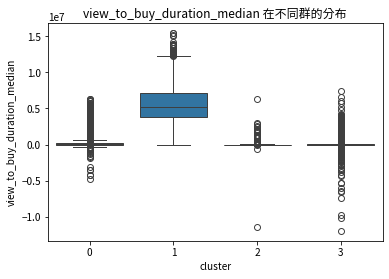

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# 分群與數值特徵分佈視覺化
col_name = 'view_to_buy_duration_median'
sns.boxplot(x='cluster', y=f'{col_name}', data=member_df)
plt.title(f'{col_name} 在不同群的分布')
plt.show()

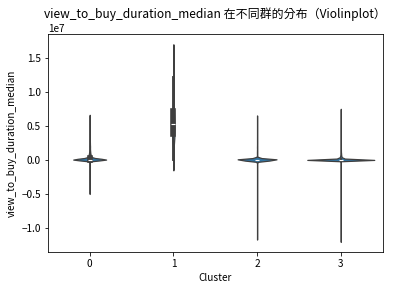

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(x='cluster', y=f'{col_name}', data=member_df)
plt.title(f'{col_name} 在不同群的分布（Violinplot）')
plt.xlabel('Cluster')
plt.ylabel(f'{col_name}')
plt.show()


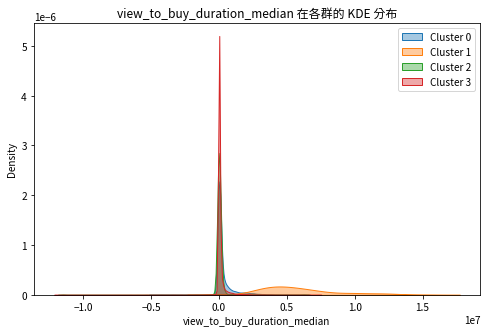

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

col_name = 'view_to_buy_duration_median'
plt.figure(figsize=(8, 5))

# 逐群畫出 KDE
for cluster_id in sorted(member_df['cluster'].unique()):
    sns.kdeplot(
        data=member_df[member_df['cluster'] == cluster_id][f'{col_name}'],
        label=f'Cluster {cluster_id}',
        fill=True, common_norm=False, alpha=0.4  # 不強制正規化喔
    )

plt.title(f'{col_name} 在各群的 KDE 分布')
plt.xlabel(f'{col_name}')
plt.ylabel('Density')
plt.legend()
plt.show()

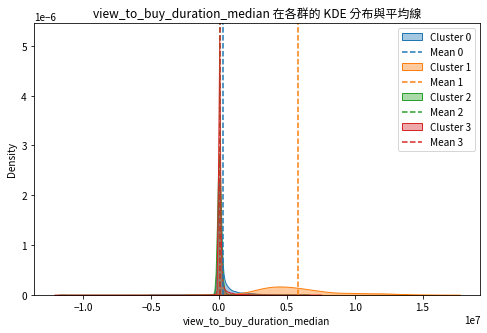

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

col_name = 'view_to_buy_duration_median'
plt.figure(figsize=(8, 5))

# 依群畫 KDE 並加上平均線
for cluster_id in sorted(member_df['cluster'].unique()):
    cluster_data = member_df[member_df['cluster'] == cluster_id][f'{col_name}']
    sns.kdeplot(cluster_data, label=f'Cluster {cluster_id}', fill=True, common_norm=False, alpha=0.4)

    # 加上平均值垂直線
    mean_val = cluster_data.mean()
    plt.axvline(mean_val, linestyle='--', linewidth=1.5, label=f'Mean {cluster_id}', color=f'C{cluster_id}')

plt.title(f'{col_name} 在各群的 KDE 分布與平均線')
plt.xlabel(f'{col_name}')
plt.ylabel('Density')
plt.legend()
plt.show()

### 4. (merge 會員、子單、商品) 抓出不同群會員的商品
- 將商品標註會員群，一個商品可能有多個群

#### 不要看，這裡會 access 到大資料

In [66]:
ODER_DIR = '/Volumes/PNYPROELITE/mo/bda/data/NOmceSRCGAE2GjCOCwaCrA==/OrderTS_Chunks'
# 抓出所有「要分析的會員」的子單資料
for i in range(1, 5, 1):
    order_df = pd.read_parquet(f'{ODER_DIR}/chunk_{i}.parquet')
    print(f'chunk_{i}.parquet (before):', order_df.shape)
    order_df = order_df[order_df['ShopMemberId'].isin(member_ids)]
    print(f'chunk_{i}.parquet (after):', order_df.shape)
    display(order_df.head(1))
    order_df.to_parquet(f'{DATA_DIR}/order_chunk_{i}.parquet', index=False)

chunk_1.parquet (before): (2730021, 21)
chunk_1.parquet (after): (533752, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
14553060,NOmceSRCGAE2GjCOCwaCrA==,Femls6ZrSM/Gl474V9HIfY8tmg4ABCg3eBKxAgRtTDk=,zTPlj+NyscXqrBmmIZZoKQ==,JUlFLFNqhLHY0mvpryCxAg==,2022-09-26 13:01:54.530,2022-10-01 11:46:16.520,OfficialECom,iOSApp,CreditCardOnce,LocationPickup,...,g3ZELDd9Kbed2V/Qp2K4zw==,7276346.0,1,90.0,45.0,90.0,0.0,-45.0,0.0,Finish


chunk_2.parquet (before): (124299, 21)
chunk_2.parquet (after): (16585, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
20000002,NOmceSRCGAE2GjCOCwaCrA==,EsPTBN97H9IqUwO4/0zWq6GlT1H9I2fL+jYKfk6iFFE=,/gbW0jkOMwc4BaHFJ8v5XA==,owxzGHQb9GbrTTZIhJCzZA==,2022-10-04 12:15:38.307,2022-10-05 01:06:08.533,OfficialECom,DesktopOfficialWeb,EasyWallet,Home,...,YT6zlMpyPI5YFD818sV/EA==,7235118.0,1,99.0,79.0,99.0,0.0,-19.0,-1.0,Finish


chunk_3.parquet (before): (1115622, 21)
chunk_3.parquet (after): (322332, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
35821974,NOmceSRCGAE2GjCOCwaCrA==,JMOd+0yolInkurgOI6TeWFk/FxDrwSkZiXHjZCp4ua8=,kvAzQJPPysCMgKx99s5x6w==,PvVC+xEHsVnEZULOIhRyAg==,2023-05-04 10:12:44.237,2023-05-04 10:12:44.267,OfficialECom,iOSApp,CreditCardOnce,Home,...,72EUVNUWwwxTlFqAw6FF+w==,7610173.0,1,69.0,58.0,69.0,0.0,-11.0,0.0,Fail


chunk_4.parquet (before): (1581096, 21)
chunk_4.parquet (after): (509005, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
40000014,NOmceSRCGAE2GjCOCwaCrA==,qvu6wYM3jN+B6stq0ffUijeHAeQJGoPsFD4uVh0zxkA=,Li9vQUStwNlb1J9YmST4Ew==,Y6RkU5zPOcXrNZZH/A9YzA==,2023-08-31 11:45:37.017,2023-08-31 22:35:10.813,N1Shopping,iOSApp,LinePay,Home,...,l5F6MgdIaau4F2FdTGLeEg==,8924965.0,1,0.0,0.0,0.0,0.0,0.0,0.0,Finish


#### 看子單

In [112]:
order_df = pd.concat([pd.read_parquet(f'{DATA_DIR}/order_chunk_{i}.parquet') for i in range(1, 5, 1)], ignore_index=True)
print("Total order_df:", order_df.shape)
display(order_df.head(1))

Total order_df: (1381674, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
0,NOmceSRCGAE2GjCOCwaCrA==,Femls6ZrSM/Gl474V9HIfY8tmg4ABCg3eBKxAgRtTDk=,zTPlj+NyscXqrBmmIZZoKQ==,JUlFLFNqhLHY0mvpryCxAg==,2022-09-26 13:01:54.530,2022-10-01 11:46:16.520,OfficialECom,iOSApp,CreditCardOnce,LocationPickup,...,g3ZELDd9Kbed2V/Qp2K4zw==,7276346.0,1,90.0,45.0,90.0,0.0,-45.0,0.0,Finish


In [113]:
# assume session 是從 2023-09-01 開始的，把 ['OrderDateTime'] < '2023-09-01' 的資料丟掉
order_df = order_df[order_df['OrderDateTime'] >= '2023-09-01']
print("After filtering OrderDateTime:", order_df.shape)
display(order_df.head(1))

After filtering OrderDateTime: (577680, 21)


,ShopId,ShopMemberId,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
550338,NOmceSRCGAE2GjCOCwaCrA==,6iNg/HozeX6XsOFy3Xw6SZNgIrFKV+D51VojSWNKg40=,o/bU8miBiMvPh8kyuHQ2/g==,JvkvUrRNzUKB32osycPevw==,2023-12-28 22:21:16.380,2023-12-29 10:35:10.357,N1Shopping,iOSApp,LinePay,Home,...,O65U++lx47sXOLohhXBNqw==,7273062.0,1,39.0,39.0,39.0,0.0,0.0,0.0,Finish


In [125]:
# 把 SalePageId 轉成 int（先轉 float，再轉 int）
order_df['SalePageId'] = order_df['SalePageId'].astype(float).astype(int)
order_df

,ShopId,MemberID,TradesGroupCode,TradesSlaveCode,OrderDateTime,OrderFinishDateTime,ChannelType,ChannelDetail,PaymentType,ShippingType,...,ProductSkuCode,SalePageId,Qty,UnitPrice,SubtotalSalesAmount,SubtotalPrice,SubtotalPromotionDiscount,SubtotalCouponDiscount,SubtotalLoyaltyPointDiscount,StatusDef
550338,NOmceSRCGAE2GjCOCwaCrA==,6iNg/HozeX6XsOFy3Xw6SZNgIrFKV+D51VojSWNKg40=,o/bU8miBiMvPh8kyuHQ2/g==,JvkvUrRNzUKB32osycPevw==,2023-12-28 22:21:16.380,2023-12-29 10:35:10.357,N1Shopping,iOSApp,LinePay,Home,...,O65U++lx47sXOLohhXBNqw==,7273062,1,39.0,39.0,39.0,0.0,0.0,0.0,Finish
550339,NOmceSRCGAE2GjCOCwaCrA==,z4ftYg1eNGJEJB1Ey7tt5038cqJDSrH2ajnHxCPu/j4=,PSnqy2dZ57oGTrWAoielSQ==,XMfGjts5t+K9TyM9q06WSg==,2024-02-11 20:49:48.067,2024-02-11 21:39:20.637,N1Shopping,iOSApp,Wallet,FamilyPickup,...,H86KGfviuY9jXK/+7ifS4g==,7553481,1,169.0,123.0,169.0,-17.0,-29.0,0.0,Cancel
550340,NOmceSRCGAE2GjCOCwaCrA==,/5Ievy2Oz71qZx72uEzsKVPpLL9ZmJGiBikW2bIEVVY=,V5AKaNUWAJYk2X2DUhw2wA==,WRPpLLaoE/TXV5J41Nc9UQ==,2023-11-05 21:11:30.327,2023-11-09 12:51:50.720,N1Shopping,iOSApp,HiLife,HiLife,...,wyZkg0h1raWTdmBVvc8o3g==,8995530,1,0.0,0.0,0.0,0.0,0.0,0.0,Finish
550342,NOmceSRCGAE2GjCOCwaCrA==,0fdyjEbG0/ytIN9rq+enYH931wA22k0kxo4a2VNLJ3A=,cBepSkDVqXllMyzbAnJXVQ==,U4B+YPebSbRLTJI39c308A==,2023-12-13 21:24:41.080,2023-12-18 20:49:48.230,N1Shopping,iOSApp,Family,Family,...,kG9k3NdJN+INqZ6LNCwPzA==,7099529,1,89.0,89.0,89.0,0.0,0.0,0.0,Finish
550343,NOmceSRCGAE2GjCOCwaCrA==,PaaupZMVcgjPFZ4b2+Tc9mwYIRZhL3fQ9TMjberDLSw=,2u+BFUlhRMt5ITNOmupxcQ==,LaT+0zrk7jWyYNMxvpHq6Q==,2023-12-12 09:54:22.237,2023-12-16 09:46:44.137,N1Shopping,iOSApp,Wallet,LocationPickup,...,nfrZHjABdUmXMP3QuHMHuA==,8802758,1,129.0,29.0,129.0,0.0,-100.0,0.0,Finish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381665,NOmceSRCGAE2GjCOCwaCrA==,pCu5Z6jRuZ1nm6j48PXR8IDk0dOIEniM2nKa8JUJKIg=,aiOTT/qEkUX9/8PSAXNhIQ==,uRaxdpE22UHr1fH9uPpgWg==,2023-09-01 20:47:01.343,2023-09-02 09:35:11.580,N1Shopping,DesktopOfficialWeb,CreditCardOnce,Home,...,+WmtqdiKaYCtZ3+HTLGHmA==,7114667,1,290.0,290.0,290.0,0.0,0.0,0.0,Finish
1381668,NOmceSRCGAE2GjCOCwaCrA==,SHjpknKDs+tisAhi5victxVdsZBfH6dgKsp+NEr4gJQ=,P19V9BWOuxENF8dJk/BTvg==,b74/qewoE7tPOq7UofI6GA==,2023-12-02 21:55:21.133,2023-12-07 19:43:05.050,N1Shopping,DesktopOfficialWeb,CreditCardOnce,FamilyPickup,...,khvUXcS/+S9drRi9Ym7heg==,7240522,1,79.0,79.0,79.0,0.0,0.0,0.0,Finish
1381669,NOmceSRCGAE2GjCOCwaCrA==,zYxPfh1xHVZa+QB5sfzQ6H8FFDHVhxU3/RCdGiyoBTs=,AfbLmWoFlylKJHhLiSAGKg==,GhQECPINoh6LmdV3vpzSkg==,2024-01-13 14:13:41.637,2024-01-19 18:02:21.513,N1Shopping,DesktopOfficialWeb,LinePay,LocationPickup,...,Sy04hLlF/JIp9/EFu0I0Fg==,8030611,1,139.0,128.0,139.0,0.0,-11.0,0.0,Finish
1381670,NOmceSRCGAE2GjCOCwaCrA==,pY5oXYHpZX3afg/EYKrDKvfUgO0AC37AXwxcoWtOuF0=,A+9HcquxhLoUdpUNPJeq2Q==,303t7AryGgEEuw9bLTOJzA==,2024-02-01 19:52:29.140,2024-02-05 13:48:31.690,N1Shopping,DesktopOfficialWeb,LinePay,LocationPickup,...,OvZEwxhHhYgJmL4lqYrpgg==,9461192,1,0.0,0.0,0.0,0.0,0.0,0.0,Finish


In [126]:
order_df['StatusDef'].value_counts()

StatusDef
Finish     475553
Cancel      75413
Fail        20300
Overdue      2655
Return       2205
New          1554
Name: count, dtype: int64

#### 依據子單，將會員分群媒合到商品

In [127]:
# 1. 將 cluster 合併到 order_df
order_df = order_df.rename(columns={'ShopMemberId': 'MemberID'})
order_with_cluster = order_df.merge(member_df[['MemberID', 'cluster']], on='MemberID', how='left')

# 2. 為每筆購買標記為 1（計數用）
order_with_cluster['purchase'] = 1

# 3. 透過 pivot_table 對 goodsID 做 cluster 統計
cluster_pivot = order_with_cluster.pivot_table(
    index='SalePageId',
    columns='cluster',
    values='purchase',
    aggfunc='sum',
    fill_value=0  # 沒有購買就補 0
)

# 4. 重命名欄位
cluster_pivot.columns = [f'cluster{int(col)}' for col in cluster_pivot.columns]

# 5. Reset index 讓 goodsID 變回欄位
result_df = cluster_pivot.reset_index()

# 6. 顯示結果
display(result_df)

,SalePageId,cluster0,cluster1,cluster2,cluster3
0,7041900,12,1,0,7
1,7041901,66,0,3,77
2,7041902,0,0,0,1
3,7041903,9,0,1,8
4,7041904,2,0,0,5
...,...,...,...,...,...
18588,9579119,0,0,0,2
18589,9579174,0,0,2,0
18590,9579192,0,0,0,2
18591,9579234,0,0,0,4


In [128]:
# 計算一個商品會屬於幾種 cluster（>= 5 才算）
result_df['num_clusters'] = result_df[[col for col in result_df.columns if col.startswith('cluster')]].apply(lambda x: (x >= 5).sum(), axis=1)

# 7. 顯示每個商品屬於幾種 cluster
print("每個商品屬於幾種 cluster:")
result_df['num_clusters'].value_counts() #.sort_index().plot(kind='bar', title='Number of Clusters per Product')

每個商品屬於幾種 cluster:


num_clusters
0    9416
2    4384
1    3608
3     944
4     241
Name: count, dtype: int64

In [129]:
# 取出不同 cluster 的商品 ids
cluster_goods = {}
for cluster_id in range(4):
    cluster_col = f'cluster{cluster_id}'
    cluster_goods[cluster_col] = result_df[result_df[cluster_col] >= 5]['SalePageId'].tolist()

### 5. 依據「商品描述」抓關鍵字

,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent
0,NOmceSRCGAE2GjCOCwaCrA==,7104874,戰神MARS搖搖杯2.0-600ml-夜幕黑,NaN
1,NOmceSRCGAE2GjCOCwaCrA==,7098357,國太樓伯爵紅茶 28.8g-蘋果風味,日本原裝進口
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠
3,NOmceSRCGAE2GjCOCwaCrA==,7048775,阿華田營養巧克力麥芽飲品 20g*13入,源自瑞士百年麥芽經典\n嚴選優質麥芽精華、濃郁可可及濃醇乳香\n兼顧健康與美味，完美調配營養...
4,NOmceSRCGAE2GjCOCwaCrA==,7076969,曼寧有機蘋香舒緩茶20入,•晚餐後或睡前最好的舒眠飲品\n•帶有蘋果甜蜜香氣的洋甘菊\n•原料來自德國，品質令人信賴
...,...,...,...,...
46240,NOmceSRCGAE2GjCOCwaCrA==,9229146,贈-Biore淨嫩沐浴乳300g櫻花香,贈-Biore淨嫩沐浴乳300g櫻花香
46241,NOmceSRCGAE2GjCOCwaCrA==,9545749,2/28-3/05贈品-氧顏森活微分子乳木果保濕面膜3入,2/28-3/05贈品-氧顏森活微分子乳木果保濕面膜3入
46242,NOmceSRCGAE2GjCOCwaCrA==,9370014,12/06-01/09門市取貨滿$590抽Apple Watch S9 LTE 41mm (...,12/06-01/09門市取貨滿$590抽Apple Watch S9 LTE 41mm (...
46243,NOmceSRCGAE2GjCOCwaCrA==,9288119,【廠商直送】贈-ILOVEPINK抱枕-2入(顏色隨機出貨)-$799,【廠商直送】贈-ILOVEPINK抱枕-2入(顏色隨機出貨)-$799


title_length range 1 81


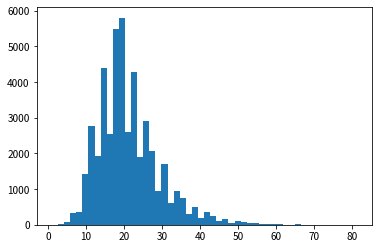

desc_length range 1.0 550.0


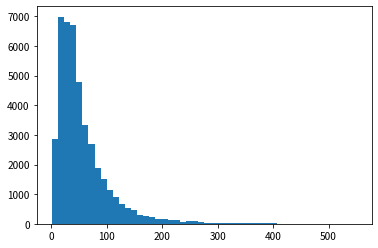

In [105]:
sale_page_df = pd.read_csv(f'{DATA_DIR}/SalePage.csv')
display(sale_page_df)

# SalePageTitle 字數分布
sale_page_df['title_length'] = sale_page_df['SalePageTitle'].str.len()
print("title_length range", sale_page_df['title_length'].min(), sale_page_df['title_length'].max())
plt.hist(sale_page_df['title_length'], bins=50)
plt.show()

# SaleProductDescShortContent 字數分布
sale_page_df['desc_length'] = sale_page_df['SaleProductDescShortContent'].str.len()
print("desc_length range", sale_page_df['desc_length'].min(), sale_page_df['desc_length'].max())
plt.hist(sale_page_df['desc_length'], bins=50)
plt.show()

In [130]:
# 將 sale_page_df 依據 cluster_goods 分組
cluster_goods_df = {}
for cluster_col, goods_ids in cluster_goods.items():
    cluster_goods_df[cluster_col] = sale_page_df[sale_page_df['SalePageId'].isin(goods_ids)].copy()
    cluster_goods_df[cluster_col]['cluster'] = cluster_col

In [133]:
for cluster_col, df in cluster_goods_df.items():
    print(f"Cluster {cluster_col} 商品數量:", df.shape[0])
    display(df.head(1))
    # 儲存到 CSV
    #df.to_csv(f'{DATA_DIR}/{cluster_col}_goods.csv', index=False)

Cluster cluster0 商品數量: 7485


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,title_length,desc_length,cluster
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠,15,38.0,cluster0


Cluster cluster1 商品數量: 511


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,title_length,desc_length,cluster
26,NOmceSRCGAE2GjCOCwaCrA==,9207710,Bodygoals 多效乳清蛋白飲31g-英式奶茶,NaN,25,NaN,cluster1


Cluster cluster2 商品數量: 1044


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,title_length,desc_length,cluster
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠,15,38.0,cluster2


Cluster cluster3 商品數量: 7132


,ShopId,SalePageId,SalePageTitle,SaleProductDescShortContent,title_length,desc_length,cluster
2,NOmceSRCGAE2GjCOCwaCrA==,7098402,曼寧健康花草茶15入-多款任選,優雅清香的玫瑰花茶\n養顏美容 散發出迷人香氣\n進口德國花草原料，品質安心可靠,15,38.0,cluster3


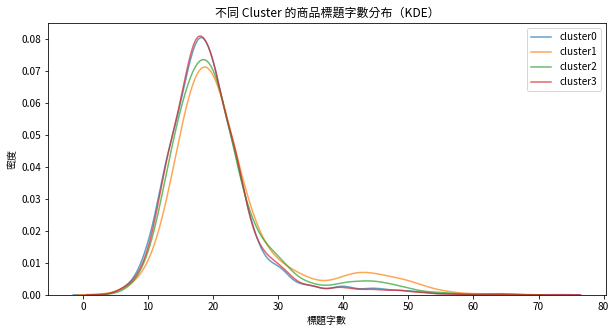

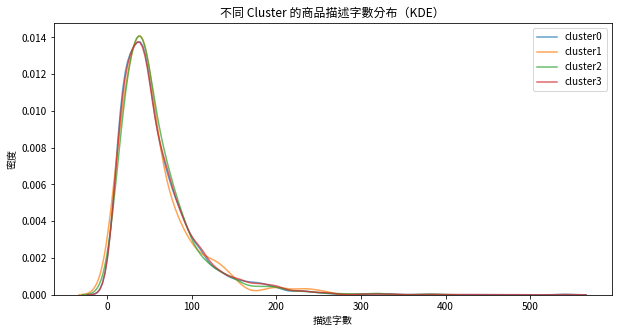

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt

# 商品標題字數 KDE 分布
plt.figure(figsize=(10, 5))
for cluster_col, df in cluster_goods_df.items():
    sns.kdeplot(df['title_length'], label=cluster_col, fill=False, alpha=0.7)
plt.title('不同 Cluster 的商品標題字數分布（KDE）')
plt.xlabel('標題字數')
plt.ylabel('密度')
plt.legend()
plt.show()

# 商品描述字數 KDE 分布
plt.figure(figsize=(10, 5))
for cluster_col, df in cluster_goods_df.items():
    sns.kdeplot(df['desc_length'], label=cluster_col, fill=False, alpha=0.7)
plt.title('不同 Cluster 的商品描述字數分布（KDE）')
plt.xlabel('描述字數')
plt.ylabel('密度')
plt.legend()
plt.show()


In [140]:
# load cut terms
sale_page_terms_df = pd.read_csv(f'{DATA_DIR}/SalePage_cutterms.csv')
print("sale_page_terms_df", sale_page_terms_df.shape)
display(sale_page_terms_df.head(1))

sale_page_terms_df (46245, 3)


,SalePageId,title_cutterms,desc_cutterms
0,7104874,戰神 mars 搖搖杯 ml 夜幕 黑,NaN


In [ ]:
# '贈' 這個詞，出現在不同商品分群的比例
def calculate_term_proportions(term, cluster_goods_df):
    proportions = {}
    for cluster_col, df in cluster_goods_df.items():
        # 標題 + 敘述
        df['SalePageText'] = df['SalePageTitle'].fillna('') + ' ' + df['SaleProductDescShortContent'].fillna('')
        term_count = df['SalePageText'].str.contains(term).sum()
        total_count = df.shape[0]
        proportions[cluster_col] = term_count / total_count if total_count > 0 else 0
    return proportions
term = '限時' # 抽, '贈', '折', '免運', '滿額', '必買'
term_proportions = calculate_term_proportions(term, cluster_goods_df)
print(f"'{term}' 在不同 Cluster 的比例:")
for cluster_col, proportion in term_proportions.items():
    print(f"{cluster_col}: {proportion:.2%}")

'限時' 在不同 Cluster 的比例:
cluster0: 2.47%
cluster1: 1.17%
cluster2: 1.82%
cluster3: 2.13%


In [ ]:
# 準備: 每個商品的斷詞、字典有多少字
# 準備: BERT 視覺化, 確定不同群會員, 對敘述風格真的有不同偏好
# 會不會就字數不一樣了啊 --> 沒有

### end